# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1GnnrrYsh1K1Jg7L9v4vOSO89UNYtLJ7D/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install torchtext==0.6.0

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
#mounting google drive for running any further code and saving the output
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [133]:
for line in open('/content/gdrive/My Drive/SMSSpamCollection'):
    if line [0:4] == "spam":
      #print label and first spam message
      print("Spam message label is :", line[0:4])
      print("First spam message is :", line)
      break

for line in open('/content/gdrive/My Drive/SMSSpamCollection'):
  if line[0:3] =="ham":
      #print label and first non-spam message
      print("Non-spam message label is :", line[0:3])
      print("First non-spam message is :", line)
      break

Spam message label is : spam
First spam message is : spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-spam message label is : ham
First non-spam message is : ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [134]:
spam_count=0
non_spam_count=0
for line in open('/content/gdrive/My Drive/SMSSpamCollection'):
    if line [0:4] == "spam":
      spam_count+=1
    else:
      non_spam_count+=1

#the number of spam and non-spam messages are counted below
print("The number of spam messages are :", spam_count)
print("The number of non-spam messages are :", non_spam_count)

The number of spam messages are : 747
The number of non-spam messages are : 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages of character inference-**

---
1) It is much easier to recognize character tokens as compared to words due to their reduced number (only 26 letters + symbols) and decreased computational memory requirements, leading to quicker results.

2) With analysis being done on single characters at a time there is no need to worry about misspelt words which would further increase the computational memory requirement, and therefore such problems can be avoided.


**Disadvantages of character inference-**

---
1) Although computation memory decreases, the power and time requirements increase in this method as a result of the need for more complex models to understand and detect possible spam messages just through characters, leading to more computational power, time and cost needs.

2) As mentioned previously, making inferences just based on a sequence of characters is a lot harder than doing so using words, as it becomes more difficult to detect spam "types" or trends that often show up. This could lead to a possible decrease in accuracy, and a loss of detection on some possible spam messages while processing.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [14]:
#using code from tutorial 6b, and replacing ham/spam with 0/1 encodings
import torchtext

text_field = torchtext.data.Field(sequential=True, # text sequence
                                  tokenize=lambda x: x, # because we are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,   #just a 0/1 encoding for the label
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert label to 0 and 1

#creating two fields as needed, one for the label encoded as 0/1 and one for the text itself
fields = [('label', label_field), ('text', text_field)]
dataset = torchtext.data.TabularDataset("/content/gdrive/My Drive/SMSSpamCollection", "tsv", fields)

#testing if this worked properly
print(dataset[0].text)
print(dataset[0].label) #should be 0 as this is a non-spam message

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0


In [26]:
#splitting the data into 60/20/20 for training/validation/testing
#using the split method provided in the link above

trainset, valset, testset = dataset.split(split_ratio=[.6, .2, .2])
print("The proportion of messages left for training are: ", round((len(trainset))/(len(trainset+valset+testset))*100), "%")
print("The proportion of messages left for validation are: ", round((len(valset))/(len(trainset+valset+testset))*100), "%")
print("The proportion of messages left for testing are: ", round((len(testset))/(len(trainset+valset+testset))*100), "%")

The proportion of messages left for training are:  60 %
The proportion of messages left for validation are:  20 %
The proportion of messages left for testing are:  20 %


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [27]:
# save the original training examples
old_train_examples = trainset.examples
# get all the spam messages in `train`
train_spam = []
for item in trainset.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
trainset.examples = old_train_examples + train_spam * 6

**Importance of a balanced dataset**

A balanced dataset is important because of two major reasons-

1) A higher non-spam message percentage automatically makes the model more biased towards predicting non-spam, and if it does so for all messages it would still end up with a high accuracy due to the imbalance. This could be indicative of a false sense of confidence in the model.

2) When testing on new data which might have significantly higher spam messages, since our model is not capable of accuractely detecting them, the accuracy will be very low leading to many wrong predictions.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [34]:
text_field.build_vocab(trainset)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)


defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ea87f1c10f0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'A': 39, 'N': 40, '3': 41, '6': 42, 'x': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'W': 48, 'P': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, '/': 56, 'G': 57, 'F': 58, 'Y': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'V': 67, 'X': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, '"': 76, 'q': 77, 'Q': 78, '(': 79, '#': 80, '@': 81, '=': 82, '>': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '_': 87, '‘': 88, '\x92': 89, '<': 90, '$': 91, '|': 92, '[': 93, ']': 94, '\x93': 95, '¡': 96, '“': 97, '%': 98

It seems that the text_field.vocab_stoi varaible stores a mapping of the character tokens and integers associated with them as key-value pairs in a dictionary. stoi refers to string to integer.

It seems that the text_field.vocab.itos variable stores a list of character tokens that are mapped through integer values from the text_field.vocab.stoi varaiable defined before. itos referes to integer to string.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In the variables, "unk" refers to unknown character tokens that showed up while iterating through the training set, this could not be fit into any of the existing tokens python recognizes.

Similarly, "pad" refers to the padding that is applied to these texts in the training set. This is primarily done so that all the texts have equal length and it becomes a lot easier for python to process and detect for spam.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [136]:
train_iter = torchtext.data.BucketIterator(trainset,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

#setting up validation and testing iteration functions for use later using the reference code provided above
valid_iter = torchtext.data.BucketIterator(valset,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(testset,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,    # sort within each batch
                                           repeat=False)              # repeat the iterator for many epochs

In [156]:
i = 1
for batch in train_iter:
    pad = 0
    #getting the max batch length for each batch
    print("Maximum Length in batch", i , "=" , int(batch.text[1][0]))
    for text in batch.text[1]:
      #getting the pad tokens by subtracting text length from batch length
        pad += batch.text[1][0] - text
    print("Number of pad tokens in batch", i, "=" , int(pad))
    print()

#iterating through the first 10 batches
    if i<=9:
      i += 1
    else:
      break

Maximum Length in batch 1 = 45
Number of pad tokens in batch 1 = 35

Maximum Length in batch 2 = 22
Number of pad tokens in batch 2 = 0

Maximum Length in batch 3 = 63
Number of pad tokens in batch 3 = 33

Maximum Length in batch 4 = 90
Number of pad tokens in batch 4 = 50

Maximum Length in batch 5 = 158
Number of pad tokens in batch 5 = 0

Maximum Length in batch 6 = 49
Number of pad tokens in batch 6 = 49

Maximum Length in batch 7 = 159
Number of pad tokens in batch 7 = 0

Maximum Length in batch 8 = 153
Number of pad tokens in batch 8 = 6

Maximum Length in batch 9 = 119
Number of pad tokens in batch 9 = 41

Maximum Length in batch 10 = 22
Number of pad tokens in batch 10 = 66



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [49]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [137]:
#using the same code from tutorial 5 to build the model
class TextRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextRNN, self).__init__()
        #using torch.eye based on the hint above for making one-hot tensor vectors
        self.emb = torch.eye(input_size) #input size comes from the text_field.vocab.itos variable we defined earlier
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #using the best recommended alternative from above for pooling
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0],
                         torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [94]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    #using code from tutorial 5, modifying the output and label names according to our dataset
    correct, total = 0, 0
    for batch in data:
        output = model(batch.text[0])
        pred = torch.argmax(torch.softmax(output, dim = 1), 1)
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += len(batch)
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

epoch number :  1 , training_accuracy :  0.8877765218795414 , training_loss :  0.6820801496505737 , validation_accuracy :  0.8286995515695067 , validation_loss :  0.6692600250244141
epoch number :  2 , training_accuracy :  0.5417406749555951 , training_loss :  0.7118902206420898 , validation_accuracy :  0.12376681614349776 , validation_loss :  0.7481022477149963
epoch number :  3 , training_accuracy :  0.853705796867431 , training_loss :  0.4956784248352051 , validation_accuracy :  0.7659192825112108 , validation_loss :  0.5703997611999512
epoch number :  4 , training_accuracy :  0.9034393670272889 , training_loss :  0.36947160959243774 , validation_accuracy :  0.9067264573991032 , validation_loss :  0.4551020860671997
epoch number :  5 , training_accuracy :  0.9229775553043759 , training_loss :  0.1749158799648285 , validation_accuracy :  0.9336322869955157 , validation_loss :  0.29994648694992065
epoch number :  6 , training_accuracy :  0.9386404004521234 , training_loss :  0.1460730

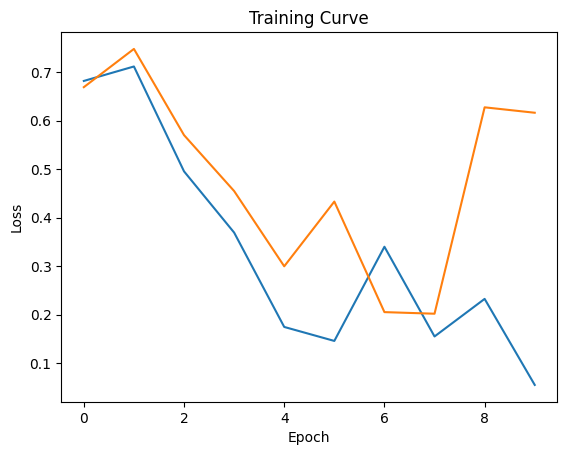

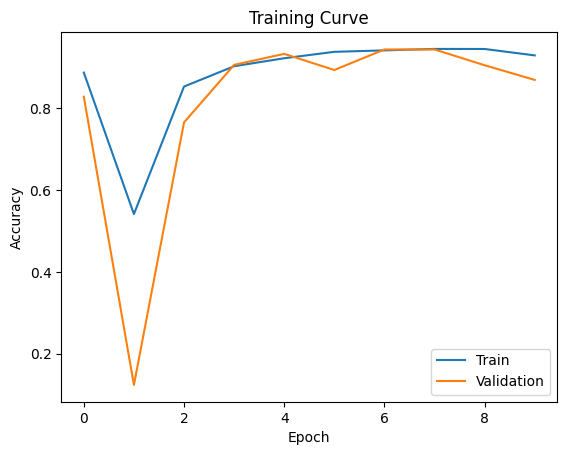

In [139]:
#using code from tutorial 5 notebook to setup the training function
def train_rnn_network(model, train, valid, num_epochs=10, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epochs = []

    #to get training time using code from lab 2
    import time
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch in train:
            optimizer.zero_grad()
            pred = model(batch.text[0])
            train_loss = criterion(pred, batch.label)
            train_loss.backward()
            optimizer.step()
        train_losses.append(float(train_loss))

        for batch in valid:
            pred = model(batch.text[0])
            val_loss = criterion(pred, batch.label)
        val_losses.append(float(val_loss))

        #using code from lab 2 and lab 3 to store the training and validation errors and losses for each epoch
        epochs.append(epoch)
        train_accs.append(get_accuracy(model, train))
        val_accs.append(get_accuracy(model, valid))
        #printing the training accuracy and losses for all epochs to understand the training and validation effectiveness
        print("epoch number : ", epoch+1, ", training_accuracy : ",train_accs[epoch],", training_loss : ",train_losses[epoch],
              ", validation_accuracy : ",val_accs[epoch],", validation_loss : ",val_losses[epoch])

    #recording the time elapsed
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    import matplotlib.pyplot as plt
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label ="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_accs, label="Train")
    plt.plot(epochs, val_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

#for showing the training curves of the final model we settled on for now
input_size = len(text_field.vocab.itos)
model = TextRNN(input_size,50,2)
train_rnn_network(model, train_iter, valid_iter, num_epochs=10, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
#Based on baseline, I reduced the learning_rate to 1e-5 as I thought it was training too quick, now with the first model below it seems that the training
#accuracy plateaued for all epochs but then went up again just before the end but was not increasing throughout till the end on 10 epochs. The validation
#and training losses also seem to reduce in correlation with each other, suggesting there is no under/overfitting as of now. So I will first try making the
#learning_rate higher again but keeping the other hyperparameters the same at hidden_size = 50, batch_size = 32, to understand what changes to make next.

input_size = len(text_field.vocab.itos)
model = TextRNN(input_size,50,2)
train_rnn_network(model, train_iter, valid_iter, num_epochs=10, learning_rate=1e-5)

#Results from this configuration of the model
#num_epochs = 10, hidden_size = 50, batch_size = 32, learning_rate = 1e-5
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  10 , training_accuracy :  0.5404488939124819 , training_loss :  0.6749295592308044 , validation_accuracy :  0.12466367713004484 ,
#validation_loss :  0.7223743796348572

In [ ]:
#Based on training with the second model below it seems that the training accuracy plateaued for epochs 5-8 but then went up again just before the end
#and was increasing throughout till the end on 10 epochs. The validation and training losses also seem to reduce in correlation with each other,
#suggesting there is no under/overfitting as of now. So I will first try making the hidden_size higher but keeping the other hyperparameters the same
#at learning_rate = 2e-4, batch_size = 32, to understand what changes to make next.

input_size = len(text_field.vocab.itos)
model_2 = TextRNN(input_size,50,2)
train_rnn_network(model_2, train_iter, valid_iter, num_epochs=10, learning_rate=2e-4)

#Results from this configuration of the model
#num_epochs = 10, hidden_size = 50, batch_size = 32, learning_rate = 2e-4
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  10 , training_accuracy :  0.9681898918133376 , training_loss :  0.0719970092177391 , validation_accuracy :  0.947085201793722 ,
#validation_loss :  0.06336966156959534

In [ ]:
#Based on training with the third model below it seems that the training accuracy never plateaued for any epochs,
#and was increasing throughout till the end on 10 epochs. The validation and training losses however, don't seem to reduce in correlation with each other,
#suggesting there is some overfitting as of now. So I will first try making the pooling function differently but keeping the other hyperparameters the same
#at learning_rate = 2e-4, hidden_size = 100, to understand what changes to make next.

input_size = len(text_field.vocab.itos)
model = TextRNN(input_size,100,2)
train_rnn_network(model, train_iter, valid_iter, num_epochs=10, learning_rate=2e-4)

#Results from this configuration of the model
#num_epochs = 10, hidden_size = 100 batch_size = 32, learning_rate = 2e-4
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  9 , training_accuracy :  0.9683513644437268 , training_loss :  0.04178082197904587 , validation_accuracy :  0.9605381165919282 ,
#validation_loss :  0.15539869666099548

In [ ]:
#using the same code from tutorial 5 to build the model
class TextRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextRNN2, self).__init__()
        self.emb = torch.eye(input_size) #input size comes from the text_field.vocab.itos variable we defined earlier
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #using the best recommended alternative from above for pooling
        out, _ = self.rnn(x)
        out=self.fc(out[:, -1, :])
        return out

#Based on training with the fourth model below it seems that the training accuracy never plateaued for any epochs,
#and was increasing throughout till the end on 10 epochs. The validation and training losses however, don't seem to reduce in correlation with each other,
#suggesting there is some overfitting as of now.

input_size = len(text_field.vocab.itos)
model = TextRNN2(input_size,100,2)
train_rnn_network(model, train_iter, valid_iter, num_epochs=10, learning_rate=2e-5)

#Results from this configuration of the model
#num_epochs = 10, hidden_size = 100 batch_size = 32, learning_rate = 2e-5
#The most optimal training and validation losses and accuracies are included in the line below.
#epoch number :  9 , training_accuracy :  0.9140965606329727 , training_loss :  0.10730357468128204 , validation_accuracy :  0.9049327354260089 ,
#validation_loss :  0.24741205573081978

#seems like this model still performs similar to model 3

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [119]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valset.examples if e.label == 1],
    valset.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valset.examples if e.label == 0], #changed to 0 to obtain non-spam set
    valset.fields)

#we now need to iterate through these datasets, so using a similar iteration function as before
valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

valid_no_spam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

#since model 2 was the best model, we are going to use that model to get all the accuracies for false positives and false negatives
print("Proportion of false positives in validation set:", round((1 - get_accuracy(model_2, valid_no_spam_iter))*100,2), "%")
print("Proportion of false negatives in validation set:", round((1 - get_accuracy(model_2, valid_spam_iter))*100,2), "%")

Proportion of false positives in validation set: 3.16 %
Proportion of false negatives in validation set: 8.96 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Problem with False Positives**

False positives could result in important messages that I would recieve from banks for transactions, hospitals and restaurants for appointments or bookings could possibly be marked as spam due to the way they are written. This would result in missing important deadlines or requirements and could possibly be very bad for the person. This is a lot more dangerous than false negatives.

**Problem with False Negatives**

False negatives could result in the increase of spam messages that should be filtered by being marked as non-spam on my phone. Although this is a hinderance and could possibly lead to phishing or data leaks if links are clicked without notice, most people already recognize these sorts of messages and ignore them. I would still say this is less dangerous than false positives.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [116]:
#finding the accuracy of the model on the testing data set
print("Model testing accuracy :", round(get_accuracy(model_2, test_iter)*100,2), "%")

Model testing accuracy : 97.49 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [120]:
#basically reusing the code from above part 3d
# Create a Dataset of only spam testing examples
test_spam = torchtext.data.Dataset(
    [e for e in testset.examples if e.label == 1],
    testset.fields)
# Create a Dataset of only non-spam testing examples
test_nospam = torchtext.data.Dataset(
    [e for e in testset.examples if e.label == 0], #changed to 0 to obtain non-spam set
    testset.fields)

#we now need to iterate through these datasets, so using a similar iteration function as before
test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_no_spam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

#since model 2 was the best model, we are going to use that model to get all the accuracies for false positives and false negatives
print("Proportion of false positives in testing set :", round((1 - get_accuracy(model_2, test_no_spam_iter))*100,2), "%")
print("Proportion of false negatives in testing set :", round((1 - get_accuracy(model_2, test_spam_iter))*100,2), "%")

Proportion of false positives in testing set : 2.56 %
Proportion of false negatives in testing set : 3.62 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [132]:
msg = "machine learning is sooo cool!"
msg_list = []
for i in range(len(msg)):
    msg_list.append(msg[i])
for i in range(len(msg_list)):
    #using the string to integer variable defined earlier to obtain the message in integer form for passing to model
    msg_list[i]=text_field.vocab.stoi[msg[i]]
#converting the list form to a tensor for passing to the model
input = torch.LongTensor(msg_list).unsqueeze(dim=0)

#using the same setup as in get_accuracy to identify spam probability using torch.softmax
print("Probability of the above message being spam :", round(float((torch.softmax(model_2(input), dim=1)[0][1]*100)),2), "%")

Probability of the above message being spam : 6.29 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam messages is a relatively tough but not very difficult task just based on the amount of different ways a spam message could be detected. However, the possibility of potentially having a false negative or a false positive which could be dangerous does add an element of risk to it which should be reduced as much as possible.

The simplest baseline model I can think off which would work decently well on detecting spam messages is just using common "spam words" and also a grammar/punctuation check. In most instances, spam messages have poorly framed sentences and punctuation mistakes which can easily be detected by checking for proper sentence structure using the baseline model we make.

Also, spam messaged tend to often send out links or ask for details, so setting up our model in such a way that these two things are kept track off could be a good way to detect possible spam messages, however, it is still important to consider the possibility of links being from a reputables source and not just marking a message spam based on the fact that a link is present.

The simplest model I can think off uses linear regression and fully connected layers to output a 0/1 encoding for any message that it reads based on the probability/weights of certain words appearing. Further, I would say it is important for the model to also detect how many above the aforementioned violations are present, and then mark it as spam if a majority are present, since there is a higher chance just based on general trends.

This model would obviously have inconsistencies while detecting the possibility of spam messages so it should not be the sole basis of judgement when checking for spam messages.